Set `autoreload` to execute the change in `.py` files.


In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import natsort
import glob
import cv2
import dlib

print(dlib.DLIB_USE_CUDA)
print(dlib.cuda.get_num_devices())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import _pickle
import sys
from pathlib import Path


dataset_dir = "D:/Databases/CAS(ME)^2"
# dataset_dir = "F:/HEH/Databases/CAS(ME)^2"
# dataset_dir = "/data/disk1/heh/databases/CAS(ME)^2"

# dataset_dir = "D:/Databases/SAMM_longvideos"
# dataset_dir = "F:/HEH/Databases/SAMM_longvideos"
# dataset_dir = "/data/disk1/heh/databases/SAMM_longvideos"

test_dataset_dir = "D:/Databases/MEGC2022_testSet/CAS_Test_cropped"
# test_dataset_dir = "F:/HEH/Databases/MEGC2022_testSet/CAS_Test_cropped"
# test_dataset_dir = "/data/disk1/heh/databases/MEGC2022_testSet/CAS_Test_cropped"

# test_dataset_dir = "D:/Databases/MEGC2022_testSet/SAMM_Test_cropped"
# test_dataset_dir = "F:/HEH/Databases/MEGC2022_testSet/SAMM_Test_cropped"
# test_dataset_dir = "/data/disk1/heh/databases/MEGC2022_testSet/SAMM_Test_cropped"

images_loading = False
image_size = 128
load_cropped_images = False
# expression_type = "mae"  # macro-expression spotting
expression_type = "me"  # micro-expression spotting
save_x = False
debug_preds = True
labeling_function = "pseudo_labeling"
# labeling_function = "original_labeling"
model_names = {
    0: "SOFTNet",
    1: "SOFTNetCBAM",
    2: "ViT-B",
    3: "SL-ViT-B",
    4: "Swin-T",
    5: "Swin-S",
    6: "L-Swin-T",
    7: "S-Swin-T",
    8: "SL-Swin-T",
    9: "SL-Swin-S",
}
batch_size = 48
epochs = 25
save_preds = False

mae_model_name = model_names[8]
mae_preds_stem = (
    f"mae_"
    + mae_model_name.lower().replace("-", "_")
    + f"_batch_size_{batch_size}"
    + f"_epochs_{epochs}"
    + f"_{labeling_function}"
    + f"_{image_size}"
    # + "_1"
)
mae_preds_path = Path(dataset_dir, "preds", mae_preds_stem).with_suffix(".pkl")
print(f"mae_preds_path: {mae_preds_path}")

me_model_name = model_names[8]
me_preds_stem = (
    f"me_"
    + me_model_name.lower().replace("-", "_")
    + f"_batch_size_{batch_size}"
    + f"_epochs_{epochs}"
    + f"_{labeling_function}"
    + f"_{image_size}"
    + "_3"
)
me_preds_path = Path(dataset_dir, "preds", me_preds_stem).with_suffix(".pkl")
print(f"me_preds_path: {me_preds_path}")

model_name = model_names[8]
test_preds_parent = Path(test_dataset_dir).parent / Path(
    Path(test_dataset_dir).name.split("_")[0]
    + "_"
    + Path(test_dataset_dir).name.split("_")[1],
    "preds",
)
test_preds_stem = (
    f"{expression_type}_"
    + model_name.lower().replace("-", "_")
    + f"_batch_size_{batch_size}"
    + f"_epochs_{epochs}"
    + f"_{labeling_function}"
    + f"_{image_size}"
)
test_preds_path = Path(test_preds_parent, test_preds_stem).with_suffix(".pkl")
print(f"test_preds_path: {test_preds_path}")


True
1
mae_preds_path: D:\Databases\CAS(ME)^2\preds\mae_sl_swin_t_batch_size_48_epochs_25_pseudo_labeling_128.pkl
me_preds_path: D:\Databases\CAS(ME)^2\preds\me_sl_swin_t_batch_size_48_epochs_25_pseudo_labeling_128_3.pkl
test_preds_path: D:\Databases\MEGC2022_testSet\CAS_Test\preds\me_sl_swin_t_batch_size_48_epochs_25_pseudo_labeling_128.pkl


## Load Images 


When debug the image processing, the videos_images is from cropped_rawpic, whereas the other variables are from rawpic.


In [32]:
from image_processing import *

# videos_images, subjects, subjects_videos_code = load_images(dataset_dir)

videos_images, subjects, subjects_videos_code = load_images_dev(
    dataset_dir,
    images_loading=images_loading,
    image_size=image_size,
    load_cropped_images=load_cropped_images,
)


subject:  s15
subject:  s16
subject:  s19
subject:  s20
subject:  s21
subject:  s22
subject:  s23
subject:  s24
subject:  s25
subject:  s26
subject:  s27
subject:  s29
subject:  s30
subject:  s31
subject:  s32
subject:  s33
subject:  s34
subject:  s35
subject:  s36
subject:  s37
subject:  s38
subject:  s40


In [33]:
print("subjects:", subjects)
print("subjects_videos_code:", subjects_videos_code)


subjects: ['s15', 's16', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's40']
subjects_videos_code: [['0101', '0102', '0401', '0402', '0502', '0503', '0505', '0508'], ['0101', '0102', '0401', '0402', '0502', '0505', '0507'], ['0102', '0402', '0505', '0507', '0502'], ['0502'], ['0101', '0401'], ['0101', '0102', '0402', '0503', '0508'], ['0102', '0402', '0503', '0507'], ['0101', '0401', '0402', '0502', '0507'], ['0101', '0102', '0502', '0508'], ['0101', '0102', '0401', '0503'], ['0101', '0102', '0401', '0402', '0502', '0503', '0505', '0507', '0508'], ['0502'], ['0101', '0102', '0401', '0502', '0503', '0505', '0507'], ['0101', '0401', '0402', '0502', '0503', '0505', '0507'], ['0101', '0102', '0401', '0402', '0502', '0503', '0505', '0507', '0508'], ['0102', '0402'], ['0401', '0402', '0503'], ['0102'], ['0401', '0505'], ['0101', '0402', '0502', '0505', '0507', '0508'], ['0502', '0507'], ['0401', '0502', '

In [34]:
from image_processing import *

test_videos_images, test_subjects, test_videos_name = load_images_dev(
    test_dataset_dir,
    images_loading=images_loading,
    image_size=image_size,
    load_cropped_images=load_cropped_images,
)


test_subject_video_code:  sub01
test_subject_video_code:  sub02
test_subject_video_code:  sub03
test_subject_video_code:  sub04
test_subject_video_code:  sub05


In [35]:
print("test_subjects:", test_subjects)
print("test_videos_name:", test_videos_name)


test_subjects: ['sub01', 'sub02', 'sub03', 'sub04', 'sub05']
test_videos_name: ['sub01', 'sub02', 'sub03', 'sub04', 'sub05']


## load Excel


In [38]:
from label_processing import load_excel

Excel_data = load_excel(dataset_dir)


In [39]:
Excel_data.head(5)


,participant,video_name_&_expression_number,onset,apex,offset,AUs,extimated_emotion,expression_type,self-reported_emotion,video_name,video_code,subject
0,1,anger1_1,557,572,608,4+10+14+15,negative,macro-expression,anger,anger1,0401,s15
1,1,anger1_2,2854,2862,2871,38,others,macro-expression,sadness,anger1,0401,s15
2,1,anger2_1,2155,2163,0,NaN,negative,macro-expression,anger,anger2,0402,s15
3,1,anger2_2,3363,3371,3383,4+7+14,negative,macro-expression,anger,anger2,0402,s15
4,1,anger2_3,3380,3386,3407,4+14+38,negative,macro-expression,anger,anger2,0402,s15


## Load Ground Truth Labels


In [40]:
from label_processing import load_ground_truth_labels


(
    clean_videos_images,
    clean_subjects_videos_code,
    clean_subjects,
    clean_subjects_videos_ground_truth_labels,
) = load_ground_truth_labels(
    dataset_dir,
    expression_type,
    videos_images,
    subjects_videos_code,
    subjects,
    Excel_data,
)


required_videos_index:  [1, 4, 8, 9, 12, 13, 14, 16, 28, 33, 36, 37, 38, 45, 46, 47, 49, 50, 52, 54, 55, 57, 62, 64, 67, 71, 73, 74, 77, 83, 87, 91, 93]
len(clean_videos_images) = 33


In [41]:
print("len(clean_subjects): ", len(clean_subjects))
print("clean_subjects: ", clean_subjects)
print("len(clean_subjects_videos_code): ", len(clean_subjects_videos_code))
print("clean_subjects_videos_codes: ", clean_subjects_videos_code)
print(
    "len(clean_subjects_videos_ground_truth_labels): ",
    len(clean_subjects_videos_ground_truth_labels),
)
print(
    "clean_subjects_videos_ground_truth_labels: ",
    clean_subjects_videos_ground_truth_labels,
)


len(clean_subjects):  14
clean_subjects:  ['s15' 's16' 's19' 's23' 's24' 's25' 's27' 's29' 's30' 's31' 's32' 's35'
 's37' 's38']
len(clean_subjects_videos_code):  14
clean_subjects_videos_codes:  [['0102', '0502'], ['0101', '0102', '0502', '0505', '0507'], ['0402'], ['0102'], ['0401', '0507'], ['0101', '0102'], ['0101', '0102', '0401', '0502', '0503', '0507'], ['0502'], ['0101', '0401'], ['0101', '0402', '0505'], ['0401', '0502', '0503', '0508'], ['0102'], ['0402', '0508'], ['0507']]
len(clean_subjects_videos_ground_truth_labels):  14
clean_subjects_videos_ground_truth_labels:  [[[[698, 706]], [[137, 147]]], [[[551, 564]], [[269, 277]], [[322, 333]], [[395, 406], [1694, 1709], [1879, 1894]], [[1957, 1967], [2284, 2294]]], [[[1926, 1941]]], [[[330, 345], [525, 539], [726, 739]]], [[[607, 620], [962, 976], [1889, 1901], [2180, 2192], [3440, 3452]], [[1835, 1847], [1950, 1964], [3232, 3247]]], [[[112, 126]], [[995, 1007], [1007, 1016], [1017, 1033]]], [[[873, 887]], [[33, 47], [308, 316],

In [42]:
from label_processing import load_ground_truth_labels


(
    mae_clean_videos_images,
    mae_clean_subjects_videos_code,
    mae_clean_subjects,
    mae_clean_subjects_videos_ground_truth_labels,
) = load_ground_truth_labels(
    dataset_dir,
    "mae",
    videos_images,
    subjects_videos_code,
    subjects,
    Excel_data,
)


required_videos_index:  [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]
len(clean_videos_images) = 88


In [43]:
print("len(mae_clean_subjects): ", len(mae_clean_subjects))
print("mae_clean_subjects: ", mae_clean_subjects)
print("len(mae_clean_subjects_videos_code): ", len(mae_clean_subjects_videos_code))
print("mae_clean_subjects_videos_codes: ", mae_clean_subjects_videos_code)
print(
    "len(mae_clean_subjects_videos_ground_truth_labels): ",
    len(mae_clean_subjects_videos_ground_truth_labels),
)
print(
    "mae_clean_subjects_videos_ground_truth_labels: ",
    mae_clean_subjects_videos_ground_truth_labels,
)


len(mae_clean_subjects):  20
mae_clean_subjects:  ['s15' 's16' 's19' 's20' 's21' 's22' 's23' 's24' 's25' 's26' 's27' 's30'
 's31' 's32' 's33' 's34' 's36' 's37' 's38' 's40']
len(mae_clean_subjects_videos_code):  20
mae_clean_subjects_videos_codes:  [['0101', '0102', '0401', '0402', '0502', '0503', '0505'], ['0101', '0102', '0401', '0402', '0502', '0505', '0507'], ['0102', '0505', '0507'], ['0502'], ['0101', '0401'], ['0101', '0102', '0402', '0503', '0508'], ['0102', '0402', '0507'], ['0101', '0401', '0402', '0502', '0507'], ['0102', '0502', '0508'], ['0101', '0102', '0401', '0503'], ['0101', '0102', '0401', '0402', '0502', '0503', '0505', '0507', '0508'], ['0102', '0401', '0502', '0503', '0505', '0507'], ['0101', '0401', '0402', '0502', '0503', '0505', '0507'], ['0101', '0102', '0401', '0402', '0502', '0503', '0505', '0507'], ['0102', '0402'], ['0401', '0402', '0503'], ['0401', '0505'], ['0101', '0402', '0502', '0505', '0507', '0508'], ['0502', '0507'], ['0401', '0502', '0503']]
len(mae

In [44]:
from label_processing import load_ground_truth_labels


(
    me_clean_videos_images,
    me_clean_subjects_videos_code,
    me_clean_subjects,
    me_clean_subjects_videos_ground_truth_labels,
) = load_ground_truth_labels(
    dataset_dir,
    "me",
    videos_images,
    subjects_videos_code,
    subjects,
    Excel_data,
)


required_videos_index:  [1, 4, 8, 9, 12, 13, 14, 16, 28, 33, 36, 37, 38, 45, 46, 47, 49, 50, 52, 54, 55, 57, 62, 64, 67, 71, 73, 74, 77, 83, 87, 91, 93]
len(clean_videos_images) = 33


In [45]:
print("len(me_clean_subjects): ", len(me_clean_subjects))
print("me_clean_subjects: ", me_clean_subjects)
print("len(me_clean_subjects_videos_code): ", len(me_clean_subjects_videos_code))
print("me_clean_subjects_videos_codes: ", me_clean_subjects_videos_code)
print(
    "len(me_clean_subjects_videos_ground_truth_labels): ",
    len(me_clean_subjects_videos_ground_truth_labels),
)
print(
    "me_clean_subjects_videos_ground_truth_labels: ",
    me_clean_subjects_videos_ground_truth_labels,
)


len(me_clean_subjects):  14
me_clean_subjects:  ['s15' 's16' 's19' 's23' 's24' 's25' 's27' 's29' 's30' 's31' 's32' 's35'
 's37' 's38']
len(me_clean_subjects_videos_code):  14
me_clean_subjects_videos_codes:  [['0102', '0502'], ['0101', '0102', '0502', '0505', '0507'], ['0402'], ['0102'], ['0401', '0507'], ['0101', '0102'], ['0101', '0102', '0401', '0502', '0503', '0507'], ['0502'], ['0101', '0401'], ['0101', '0402', '0505'], ['0401', '0502', '0503', '0508'], ['0102'], ['0402', '0508'], ['0507']]
len(me_clean_subjects_videos_ground_truth_labels):  14
me_clean_subjects_videos_ground_truth_labels:  [[[[698, 706]], [[137, 147]]], [[[551, 564]], [[269, 277]], [[322, 333]], [[395, 406], [1694, 1709], [1879, 1894]], [[1957, 1967], [2284, 2294]]], [[[1926, 1941]]], [[[330, 345], [525, 539], [726, 739]]], [[[607, 620], [962, 976], [1889, 1901], [2180, 2192], [3440, 3452]], [[1835, 1847], [1950, 1964], [3232, 3247]]], [[[112, 126]], [[995, 1007], [1007, 1016], [1017, 1033]]], [[[873, 887]], [[33

## Calculate k


In [46]:
from label_processing import calculate_k

k = calculate_k(clean_subjects_videos_ground_truth_labels)


k (Half of average length of expression) =  6


In [47]:
from label_processing import calculate_k

mae_k = calculate_k(mae_clean_subjects_videos_ground_truth_labels)
me_k = calculate_k(me_clean_subjects_videos_ground_truth_labels)


k (Half of average length of expression) =  18
k (Half of average length of expression) =  6


## Debug Feature Extraction

subject:  s15
cropped_videos_images[0][0]: D:\Databases\CAS(ME)^2\cropped_rawpic\s15\15_0101disgustingteeth\img001.jpg
cropped_videos_images[0][0]: D:\Databases\CAS(ME)^2\cropped_rawpic\s15\15_0101disgustingteeth\img001.jpg


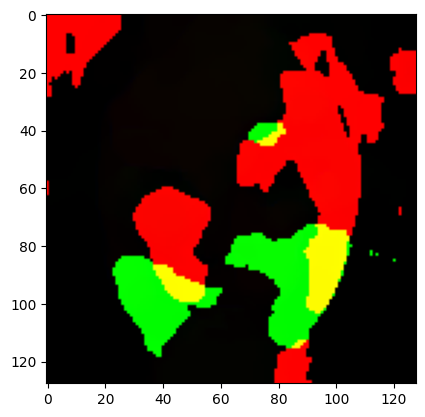

In [48]:
def compute_optical_strain(u, v):
    u_x = u - pd.DataFrame(u).shift(-1, axis="columns")
    v_y = v - pd.DataFrame(v).shift(-1, axis="index")
    u_y = u - pd.DataFrame(u).shift(-1, axis="index")
    v_x = v - pd.DataFrame(v).shift(-1, axis="columns")
    optical_strain = np.array(
        np.sqrt(u_x**2 + v_y**2 + 1 / 2 * (u_y + v_x) ** 2)
        .ffill(axis="columns")
        .ffill(axis="index")
    )
    return optical_strain


cropped_videos_images, _, _ = load_images_dev(
    dataset_dir,
    images_loading=images_loading,
    image_size=image_size,
    load_cropped_images=True,
)
print(f"cropped_videos_images[0][0]: {cropped_videos_images[0][0]}")
image1 = cropped_videos_images[0][0]
print(f"cropped_videos_images[0][0]: {cropped_videos_images[0][0]}")
image2 = cropped_videos_images[0][0 + k]

if type(image1).__name__ != "ndarray":
    # cv2 needs a str
    image1 = cv2.imread(str(image1), 0)
    image2 = cv2.imread(str(image2), 0)
    if image_size == 128:
        image1 = cv2.resize(image1, (image_size, image_size))
        image2 = cv2.resize(image2, (image_size, image_size))
    elif image_size == 256:
        pass

"""
https://docs.opencv.org/4.7.0/df/dde/classcv_1_1DenseOpticalFlow.html
"""

# Compute Optical Flow Features
# optical_flow = cv2.DualTVL1OpticalFlow_create() #Depends on cv2 version
optical_flow_create = cv2.optflow.DualTVL1OpticalFlow_create()
optical_flow = optical_flow_create.calc(image1, image2, None)
u, v = optical_flow[..., 0], optical_flow[..., 1]
optical_strain = compute_optical_strain(u, v)

# calculate opical flow features using Gunnar Farneback algorithm
# optical_flow = cv2.calcOpticalFlowFarneback(
#     image1, image2, None, 0.5, 3, 15, 5, 7, 1.5, 0
# )

# Features Concatenation into 128x128x3
# clean_video_image_features = np.zeros((128, 128, 3))
video_image_features = np.zeros((image_size, image_size, 3))
video_image_features[:, :, 0] = u
video_image_features[:, :, 1] = v
video_image_features[:, :, 2] = optical_strain

# Normalizationg
# video_image_features = vi.uint8(255 * vdeo_image_features - np.min(video_image_features)
# video_image_features = video_image_features / np.max(video_image_features)
# video_image_features = npideo_image_features)

plt.imshow(video_image_features.astype("uint8"))
# cv2.cvtColor(video_image_features, cv2.COLOR_RGB2BGR, video_image_features)
# cv2.imwrite("video_image_features.png", video_image_features)


## Debug Preprocess


In [57]:
predictor_model = "__utils__/shape_predictor_68_face_landmarks.dat"
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)
resampled_video_images_features = []
reference_image = videos_images[0][0]
if type(reference_image).__name__ != "ndarray":
    reference_image = cv2.imread(str(reference_image), 0)
if reference_image.shape[0] != image_size:
    reference_image = cv2.resize(reference_image, (image_size, image_size))
detect = face_detector(reference_image, 1)
index_shift = 0
backup_image = reference_image
if type(reference_image).__name__ != "ndarray":
    reference_image = cv2.imread(str(reference_image), 0)
if reference_image.shape[0] != image_size:
    reference_image = cv2.resize(reference_image, (image_size, image_size))
shape = face_pose_predictor(reference_image, detect[0])

# Left Eye
x11 = max(shape.part(36).x - 15, 0)
y11 = shape.part(36).y
x12 = shape.part(37).x
y12 = max(shape.part(37).y - 15, 0)
x13 = shape.part(38).x
y13 = max(shape.part(38).y - 15, 0)
# x14 = min(shape.part(39).x + 15, 128)
x14 = min(shape.part(39).x + 15, image_size)
y14 = shape.part(39).y
x15 = shape.part(40).x
# y15 = min(shape.part(40).y + 15, 128)
y15 = min(shape.part(40).y + 15, image_size)
x16 = shape.part(41).x
# y16 = min(shape.part(41).y + 15, 128)
y16 = min(shape.part(41).y + 15, image_size)

# Right Eye
x21 = max(shape.part(42).x - 15, 0)
y21 = shape.part(42).y
x22 = shape.part(43).x
y22 = max(shape.part(43).y - 15, 0)
x23 = shape.part(44).x
y23 = max(shape.part(44).y - 15, 0)
# x24 = min(shape.part(45).x + 15, 128)
x24 = min(shape.part(45).x + 15, image_size)
y24 = shape.part(45).y
x25 = shape.part(46).x
# y25 = min(shape.part(46).y + 15, 128)
y25 = min(shape.part(46).y + 15, image_size)
x26 = shape.part(47).x
# y26 = min(shape.part(47).y + 15, 128)
y26 = min(shape.part(47).y + 15, image_size)

# ROI 1 (Left Eyebrow)
x31 = max(shape.part(17).x - 12, 0)
y32 = max(shape.part(19).y - 12, 0)
# x33 = min(shape.part(21).x + 12, 128)
x33 = min(shape.part(21).x + 12, image_size)
# y34 = min(shape.part(41).y + 12, 128)
y34 = min(shape.part(41).y + 12, image_size)

# ROI 2 (Right Eyebrow)
x41 = max(shape.part(22).x - 12, 0)
y42 = max(shape.part(24).y - 12, 0)
# x43 = min(shape.part(26).x + 12, 128)
x43 = min(shape.part(26).x + 12, image_size)
# y44 = min(shape.part(46).y + 12, 128)
y44 = min(shape.part(46).y + 12, image_size)

# ROI 3 #Mouth
x51 = max(shape.part(60).x - 12, 0)
y52 = max(shape.part(50).y - 12, 0)
# x53 = min(shape.part(64).x + 12, 128)
x53 = min(shape.part(64).x + 12, image_size)
# y54 = min(shape.part(57).y + 12, 128)
y54 = min(shape.part(57).y + 12, image_size)

# Nose landmark
x61 = shape.part(28).x
y61 = shape.part(28).y

# Remove global head movement by minus nose region
video_image_features[:, :, 0] = abs(
    video_image_features[:, :, 0]
    - video_image_features[y61 - 5 : y61 + 6, x61 - 5 : x61 + 6, 0].mean()
)
video_image_features[:, :, 1] = abs(
    video_image_features[:, :, 1]
    - video_image_features[y61 - 5 : y61 + 6, x61 - 5 : x61 + 6, 1].mean()
)
video_image_features[:, :, 2] = (
    video_image_features[:, :, 2]
    - video_image_features[y61 - 5 : y61 + 6, x61 - 5 : x61 + 6, 2].mean()
)

# Eye masking
left_eye = [
    (x11, y11),
    (x12, y12),
    (x13, y13),
    (x14, y14),
    (x15, y15),
    (x16, y16),
]
right_eye = [
    (x21, y21),
    (x22, y22),
    (x23, y23),
    (x24, y24),
    (x25, y25),
    (x26, y26),
]
cv2.fillPoly(video_image_features, [np.array(left_eye)], 0)
# cv2.fillPoly(video_image_features, [np.array(right_eye)], 0)

# if image_size == 128:
#     # ROI Selection -> Image resampling into 42x22x3
#     # cv2 resize to (weight, height)
#     resampled_video_image_features = np.zeros((42, 42, 3))
#     resampled_video_image_features[:21, :, :] = cv2.resize(
#         video_image_features[min(y32, y42) : max(y34, y44), x31:x43, :],
#         (42, 21),
#     )
#     resampled_video_image_features[21:42, :, :] = cv2.resize(
#         video_image_features[y52:y54, x51:x53, :], (42, 21)
#     )
# elif image_size == 256:
#     # ROI Selection -> Image resampling into [84, 84, 3]
#     # cv2 resize to (weight, height)
#     resampled_video_image_features = np.zeros((84, 84, 3))
#     resampled_video_image_features[:42, :, :] = cv2.resize(
#         video_image_features[min(y32, y42) : max(y34, y44), x31:x43, :],
#         (84, 42),
#     )
#     resampled_video_image_features[42:84, :, :] = cv2.resize(
#         video_image_features[y52:y54, x51:x53, :], (84, 42)
#     )

# resampled_video_image_features = resampled_video_image_features - np.min(
#     resampled_video_image_features
# )
# resampled_video_image_features = resampled_video_image_features / np.max(
#     resampled_video_image_features
# )
# resampled_video_image_features = np.uint8(255 * resampled_video_image_features)

# plt.imshow(resampled_video_image_features.astype("uint8"))
# cv2.cvtColor(
#     resampled_video_image_features, cv2.COLOR_RGB2BGR, resampled_video_image_features
# )
# cv2.imwrite("pre_processed_features.png", resampled_video_image_features)


array([[[ 0.12716268,  1.18817588, -1.07835403],
        [ 0.10936426,  1.20312145, -1.06176865],
        [ 0.07538675,  1.19899907, -1.08424455],
        ...,
        [ 0.18163674,  1.42268721, -1.08825706],
        [ 0.18099602,  1.42877593, -1.07495991],
        [ 0.18271456,  1.44268055, -1.07495991]],

       [[ 0.10164915,  1.18550446, -1.07007017],
        [ 0.09698866,  1.19985222, -1.07911259],
        [ 0.08410107,  1.19541457, -1.07344472],
        ...,
        [ 0.17619259,  1.43223934, -1.07173666],
        [ 0.18665338,  1.44692196, -1.08025608],
        [ 0.1911669 ,  1.44098474, -1.08025608]],

       [[ 0.09328423,  1.21255311, -1.08288688],
        [ 0.09193133,  1.21166765, -1.07835358],
        [ 0.08934508,  1.19208905, -1.0749621 ],
        ...,
        [ 0.17421744,  1.45440451, -1.07780952],
        [ 0.18532187,  1.46312252, -1.07841761],
        [ 0.19940037,  1.46194097, -1.07841761]],

       ...,

       [[ 0.2336446 ,  2.1364353 , -1.07683044],
        [ 0

In [21]:
print(f"test_videos_images[0][0]: {test_videos_images[0][0]}")
image = cv2.imread(str(test_videos_images[0][0]))
image = cv2.resize(image, (image_size,image_size))

predictor_model = "./__utils__/shape_predictor_68_face_landmarks.dat"
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)
resampled_clean_videos_images_features = []

reference_img = image
detect = face_detector(reference_img, 1)
index_shift = 0
shape = face_pose_predictor(reference_img, detect[0])

# Left Eye
x11 = max(shape.part(36).x - 15, 0)
y11 = shape.part(36).y
x12 = shape.part(37).x
y12 = max(shape.part(37).y - 15, 0)
x13 = shape.part(38).x
y13 = max(shape.part(38).y - 15, 0)
x14 = min(shape.part(39).x + 15, image_size)
y14 = shape.part(39).y
x15 = shape.part(40).x
y15 = min(shape.part(40).y + 15, image_size)
x16 = shape.part(41).x
y16 = min(shape.part(41).y + 15, image_size)

# Right Eye
x21 = max(shape.part(42).x - 15, 0)
y21 = shape.part(42).y
x22 = shape.part(43).x
y22 = max(shape.part(43).y - 15, 0)
x23 = shape.part(44).x
y23 = max(shape.part(44).y - 15, 0)
x24 = min(shape.part(45).x + 15, image_size)
y24 = shape.part(45).y
x25 = shape.part(46).x
y25 = min(shape.part(46).y + 15, image_size)
x26 = shape.part(47).x
y26 = min(shape.part(47).y + 15, image_size)

# ROI 1 (Left Eyebrow)
x31 = max(shape.part(17).x - 12, 0)
y32 = max(shape.part(19).y - 12, 0)
x33 = min(shape.part(21).x + 12, image_size)
y34 = min(shape.part(41).y + 12, image_size)

# ROI 2 (Right Eyebrow)
x41 = max(shape.part(22).x - 12, 0)
y42 = max(shape.part(24).y - 12, 0)
x43 = min(shape.part(26).x + 12, image_size)
y44 = min(shape.part(46).y + 12, image_size)

# ROI 3 #Mouth
x51 = max(shape.part(60).x - 12, 0)
y52 = max(shape.part(50).y - 12, 0)
x53 = min(shape.part(64).x + 12, image_size)
y54 = min(shape.part(57).y + 12, image_size)

# Nose landmark
x61 = shape.part(28).x
y61 = shape.part(28).y


# Eye masking
left_eye = [
    (x11, y11),
    (x12, y12),
    (x13, y13),
    (x14, y14),
    (x15, y15),
    (x16, y16),
]
right_eye = [
    (x21, y21),
    (x22, y22),
    (x23, y23),
    (x24, y24),
    (x25, y25),
    (x26, y26),
]

# ROI Selection -> Image resampling into 42x22x3
# upper ROI
print(f"upper ROI height = {max(y34, y44) - min(y32, y42)}, weight = {x43 - x31}")
# lower ROI
print(f"lower ROI height = {y54 - y52}, weight = {x53 - x51}")


test_videos_images[0][0]: D:\Databases\MEGC2022_testSet\CAS_Test_cropped\sub01\0001.jpg
upper ROI height = 43, weight = 93
lower ROI height = 34, weight = 48


## Pseudo Labeling


In [51]:
list_pseudo_labels = []
pseudo_labeled_video_count = 0

# for (
#         clean_subject_videos_ground_truth_labels
#     ) in clean_subjects_videos_ground_truth_labels:
#         for (
#             clean_subject_video_ground_truth_labels
#         ) in clean_subject_videos_ground_truth_labels:
clean_subject_videos_ground_truth_labels = clean_subjects_videos_ground_truth_labels[0]
clean_subject_video_ground_truth_labels = clean_subject_videos_ground_truth_labels[0]
clean_subject_video_ground_truth_durations = []
if len(clean_subject_video_ground_truth_labels) == 0:
    # The last k frames are ignored
    list_pseudo_labels.append(
        [0] * (len(clean_videos_images[pseudo_labeled_video_count]) - k)
    )
else:
    for (
        clean_subject_video_ground_truth_label
    ) in clean_subject_video_ground_truth_labels:
        clean_subject_video_ground_truth_durations = np.append(
            clean_subject_video_ground_truth_durations,
            np.arange(
                clean_subject_video_ground_truth_label[0],
                clean_subject_video_ground_truth_label[1] + 1,
            ),
        )
    clean_subject_video_ground_truth_durations = np.unique(
        clean_subject_video_ground_truth_durations
    )

    video_pseudo_labels = np.zeros(
        len(clean_videos_images[pseudo_labeled_video_count]) - k
    )
    # - 1 for shape consistency
    labels_for_sliding_window = np.arange(
        len(clean_videos_images[pseudo_labeled_video_count]) - 1
    )
    view = np.lib.stride_tricks.sliding_window_view(
        labels_for_sliding_window, k
    )

    # each video may contains more than one micro-expression
    # so there may be more than one duration
    # for (
    #     clean_subject_video_ground_truth_duration
    # ) in clean_subject_video_ground_truth_durations:
    # Numerator
    numerator = (
        np.isin(view, clean_subject_video_ground_truth_durations)
        .astype(int)
        .sum(axis=1)
    )

    # Denumerator
    view_not_in_duration_count = (
        np.isin(
            view, clean_subject_video_ground_truth_durations, invert=True
        )
        .astype(int)
        .sum(axis=1)
    )
    denumerator = (
        clean_subject_video_ground_truth_durations.size
        + view_not_in_duration_count
    )

    iou = numerator / denumerator
    # Function g (Heaviside step function)
    video_pseudo_labels = np.where(iou > 0, 1, 0).tolist()

    # Integrate all videos into one list
    list_pseudo_labels += video_pseudo_labels
        
pseudo_labeled_video_count += 1


In [52]:
print(
    "clean_subjects_videos_ground_truth_labels:",
    clean_subjects_videos_ground_truth_labels,
)
print()
print(
    "clean_subjects_videos_ground_truth_labels[0]:",
    clean_subjects_videos_ground_truth_labels[0],
)
print(
    "clean_subject_videos_ground_truth_labels[0]:",
    clean_subject_videos_ground_truth_labels[0],
)
print(
    "clean_subject_video_ground_truth_duration:",
    np.arange(
        clean_subject_video_ground_truth_label[0],
        clean_subject_video_ground_truth_label[1] + 1,
    ),
)
print("len(pseudo_labels):", len(list_pseudo_labels))
# print("len(pseudo_labels_copy):", len(pseudo_labels_copy))

clean_subjects_videos_ground_truth_labels: [[[[698, 706]], [[137, 147]]], [[[551, 564]], [[269, 277]], [[322, 333]], [[395, 406], [1694, 1709], [1879, 1894]], [[1957, 1967], [2284, 2294]]], [[[1926, 1941]]], [[[330, 345], [525, 539], [726, 739]]], [[[607, 620], [962, 976], [1889, 1901], [2180, 2192], [3440, 3452]], [[1835, 1847], [1950, 1964], [3232, 3247]]], [[[112, 126]], [[995, 1007], [1007, 1016], [1017, 1033]]], [[[873, 887]], [[33, 47], [308, 316], [373, 387]], [[351, 364], [368, 381], [1134, 1146], [1973, 1985]], [[612, 627]], [[418, 431]], [[875, 889]]], [[[139, 151]]], [[[1454, 1465]], [[925, 940]]], [[[1420, 1432]], [[1688, 1701], [2189, 2203], [2376, 2388], [3802, 3814]], [[1045, 1058]]], [[[267, 277]], [[310, 323], [1170, 1183]], [[257, 271], [1030, 1043]], [[285, 300]]], [[[99, 112], [362, 370]]], [[[3501, 3513]], [[417, 429]]], [[[2231, 2246]]]]

clean_subjects_videos_ground_truth_labels[0]: [[[698, 706]], [[137, 147]]]
clean_subject_videos_ground_truth_labels[0]: [[698, 

## Debug Spotting

$$
\frac{1}{2k}
$$

In [53]:
a = np.arange(14)
print("a:", a, "\n")

view = np.lib.stride_tricks.sliding_window_view(a, 2 * k)
print(view)
view = np.mean(view, axis=1)
print("view output:", view)

print()
b = a.copy()
# b = b.astype(float)
for x in range(len(a) - 2 * k):
    print(a[x : x + 2 * k])
    b[x + k] = b[x : x + 2 * k].mean()
b = b[k:-k]
print("for output:", b)

a: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] 

[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 1  2  3  4  5  6  7  8  9 10 11 12]
 [ 2  3  4  5  6  7  8  9 10 11 12 13]]
view output: [5.5 6.5 7.5]

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
for output: [5 6]


$$
\frac{1}{2k + 1}
$$

In [54]:
a = np.arange(14)
print("a:", a, "\n")

view = np.lib.stride_tricks.sliding_window_view(a, 2 * k + 1)
print(view)
view = np.mean(view, axis=1)
print("view output:", view)

print()
b = a.copy()
# b = b.astype(float)
for x in range(len(a) - 2 * k):
    print(a[x : x + 2 * k + 1])
    b[x + k] = b[x : x + 2 * k + 1].mean()
b = b[k:-k]
print("for output:", b)

a: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] 

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13]]
view output: [6. 7.]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
for output: [6 7]


## Debug Evaluation


In [55]:
epsilon = sys.float_info.epsilon

scenarios = {
    0: {
        "dataset": "CAS(ME)^2",
        "expression_type": "me",
        "num_expression": 57,
    },
    1: {
        "dataset": "CAS(ME)^2",
        "expression_type": "mae",
        "num_expression": 298,
    },
}

scenario = scenarios[0]
true_positive = 14
false_positive = 298
false_negative = scenario["num_expression"] - true_positive
print(
    f"True Positive: {true_positive} False Posive: {false_positive} False Negative: {false_negative}"
)
# add epsilon to avoid float division by zero
precision = true_positive / (true_positive + false_positive) + epsilon
recall = true_positive / (true_positive + false_negative) + epsilon
F1_score = (2 * precision * recall) / (precision + recall) + epsilon
print(f"Precision = {precision}, Recall ={recall}, F1-Score = {F1_score}")


True Positive: 14 False Posive: 298 False Negative: 43
Precision = 0.044871794871795094, Recall =0.2456140350877195, F1-Score = 0.07588075880758863


### Debug MEGC 2022 Overall Evaluation


| Method | 3D-CNN | SL-Swin-T | Swin-T 
| --- | --- | --- | --- 
| p | --- | 0.60 | 0.60 
| CAS_Test Precision | 0.4000 | 0.1944 | 0.1521 
| CAS_Test Recall | 0.1111 | 0.1944 | 0.1944 
| CAS_Test F1-score | 0.1739 | 0.1944 | 0.1707 
| SAMM_Test Precision | 0.0845 | 0.0689 | 0.0638 
| SAMM_Test Recall | 0.1935 | 0.1290 | 0.0967 
| SAMM_Test F1-score | 0.1176 | 0.0898 | 0.0769 
| Overall Precision | 0.1235 | 0.1170 | 0.1075 
| Overall Recall | 0.1493 | 0.1641 | 0.1492 
| Overall F1-score | 0.1351 | 0.1366 | 0.1250 


original labeling

| Method | 3D-CNN | SL-Swin-T | Swin-T
| --- | --- | --- | --- |
| p | --- | 0.60 | 0.60 
| CAS_Test Precision | 0.4000 | 0.0735 | 0.1842
| CAS_Test Recall | 0.1111 | 0.1388 | 0.1944
| CAS_Test F1-score | 0.1739 | 0.0961 | 0.1891
| SAMM_Test Precision | 0.0845 | 0.0317 | 0.0689
| SAMM_Test Recall | 0.1935 | 0.0645 | 0.1290
| SAMM_Test F1-score | 0.1176 | 0.0425 | 0.0898
| Overall Precision | 0.1235 | 0.0534 | 0.1145
| Overall Recall | 0.1493 | 0.1044 | 0.1641
| Overall F1-score | 0.1351 | 0.0707 | 0.1349


### Debug MEGC 2021 Overall Evaluation


#### MaE


In [56]:
with open(mae_preds_path, "rb") as pkl_file:
    mae_preds = _pickle.load(pkl_file)
    pkl_file.close()


#### ME


In [57]:
with open(me_preds_path, "rb") as pkl_file:
    me_preds = _pickle.load(pkl_file)
    pkl_file.close()


In [58]:
from functions import *
import numpy as np
import threading
from queue import Queue

"""
The 100-threads method is almost as fast as the 10-threads method.
"""

mae_ablation_dict = {
    "p": [],
    "true_positive": [],
    "false_positive": [],
    "false_negative": [],
    "expression_count": [],
    "precision": [],
    "recall": [],
    "F1_score": [],
}
me_ablation_dict = {
    "p": [],
    "true_positive": [],
    "false_positive": [],
    "false_negative": [],
    "expression_count": [],
    "precision": [],
    "recall": [],
    "F1_score": [],
}

print(" p | TP | FP | FN | Precision | Recall | F1-Score")
p_arange = np.arange(0.01, 1.0, 0.01)
mae_dict_queues = []
mae_threads = []
me_dict_queues = []
me_threads = []
for _ in p_arange:
    mae_dict_queues.append(Queue())
    me_dict_queues.append(Queue())

for p_index, p in enumerate(p_arange):
    # mae
    mae_thread = threading.Thread(
        target=multithread_spot_and_evaluate,
        args=(
            mae_preds,
            mae_clean_subjects_videos_ground_truth_labels,
            mae_clean_videos_images,
            mae_clean_subjects,
            mae_clean_subjects_videos_code,
            mae_k,
            p,
            mae_dict_queues[p_index],
        ),
    )
    mae_thread.start()
    mae_threads.append(mae_thread)

    # me
    me_thread = threading.Thread(
        target=multithread_spot_and_evaluate,
        args=(
            me_preds,
            me_clean_subjects_videos_ground_truth_labels,
            me_clean_videos_images,
            me_clean_subjects,
            me_clean_subjects_videos_code,
            me_k,
            p,
            me_dict_queues[p_index],
        ),
    )
    me_thread.start()
    me_threads.append(me_thread)
    for mae_thread, me_thread in zip(mae_threads, me_threads):
        mae_thread.join()
        me_thread.join()
    print(f" p: {p}", end="\r")

# Attention!!!
# Different loop sequence
for p_index, p in enumerate(p_arange):
    # mae
    mae_p_segment_matrix = mae_dict_queues[p_index].get()
    mae_ablation_dict["p"] += mae_p_segment_matrix["p"]
    mae_ablation_dict["true_positive"] += mae_p_segment_matrix["true_positive"]
    mae_ablation_dict["false_positive"] += mae_p_segment_matrix["false_positive"]
    mae_ablation_dict["false_negative"] += mae_p_segment_matrix["false_negative"]
    mae_ablation_dict["expression_count"] += mae_p_segment_matrix[
        "expression_count"
    ]
    mae_ablation_dict["precision"] += mae_p_segment_matrix["precision"]
    mae_ablation_dict["recall"] += mae_p_segment_matrix["recall"]
    mae_ablation_dict["F1_score"] += mae_p_segment_matrix["F1_score"]

    # me
    me_p_segment_matrix = me_dict_queues[p_index].get()
    me_ablation_dict["p"] += me_p_segment_matrix["p"]
    me_ablation_dict["true_positive"] += me_p_segment_matrix["true_positive"]
    me_ablation_dict["false_positive"] += me_p_segment_matrix["false_positive"]
    me_ablation_dict["false_negative"] += me_p_segment_matrix["false_negative"]
    me_ablation_dict["expression_count"] += me_p_segment_matrix["expression_count"]
    me_ablation_dict["precision"] += me_p_segment_matrix["precision"]
    me_ablation_dict["recall"] += me_p_segment_matrix["recall"]
    me_ablation_dict["F1_score"] += me_p_segment_matrix["F1_score"]

    # overall
    true_positive = (
        mae_ablation_dict["true_positive"][-1]
        + me_ablation_dict["true_positive"][-1]
    )
    false_positive = (
        mae_ablation_dict["false_positive"][-1]
        + me_ablation_dict["false_positive"][-1]
    )
    false_negative = (
        mae_ablation_dict["expression_count"][-1]
        + me_ablation_dict["expression_count"][-1]
        - true_positive
    )
    precision = true_positive / (true_positive + false_positive) + epsilon
    recall = true_positive / (true_positive + false_negative) + epsilon
    F1_score = (2 * precision * recall) / (precision + recall) + epsilon
    print(
        "{:.2f} | {} | {} | {} | {:.4f} | {:.4f} | {:.4f} |".format(
            p,
            true_positive,
            false_positive,
            false_negative,
            precision,
            recall,
            F1_score,
        )
    )


 p | TP | FP | FN | Precision | Recall | F1-Score
0.01 | 203 | 7854 | 152 | 0.0252 | 0.5718 | 0.0483 |
0.02 | 201 | 7335 | 154 | 0.0267 | 0.5662 | 0.0509 |
0.03 | 201 | 6913 | 154 | 0.0283 | 0.5662 | 0.0538 |
0.04 | 200 | 6454 | 155 | 0.0301 | 0.5634 | 0.0571 |
0.05 | 199 | 6102 | 156 | 0.0316 | 0.5606 | 0.0598 |
0.06 | 195 | 5748 | 160 | 0.0328 | 0.5493 | 0.0619 |
0.07 | 194 | 5418 | 161 | 0.0346 | 0.5465 | 0.0650 |
0.08 | 189 | 5086 | 166 | 0.0358 | 0.5324 | 0.0671 |
0.09 | 185 | 4814 | 170 | 0.0370 | 0.5211 | 0.0691 |
0.10 | 183 | 4555 | 172 | 0.0386 | 0.5155 | 0.0719 |
0.11 | 182 | 4289 | 173 | 0.0407 | 0.5127 | 0.0754 |
0.12 | 180 | 4058 | 175 | 0.0425 | 0.5070 | 0.0784 |
0.13 | 175 | 3853 | 180 | 0.0434 | 0.4930 | 0.0799 |
0.14 | 175 | 3646 | 180 | 0.0458 | 0.4930 | 0.0838 |
0.15 | 174 | 3449 | 181 | 0.0480 | 0.4901 | 0.0875 |
0.16 | 172 | 3262 | 183 | 0.0501 | 0.4845 | 0.0908 |
0.17 | 169 | 3088 | 186 | 0.0519 | 0.4761 | 0.0936 |
0.18 | 169 | 2921 | 186 | 0.0547 | 0.4761 | 0.098

#### CAS(ME)^2

| Parameters | Value | Value | Value | Value
| --- | --- | --- | --- | ---
| MaE model | SL-Swin-S | SL-Swin-T | SL-Swin-S | SL-Swin-S |
| ME model | SL-Swin-T | SL-Swin-T | SL-Swin-T | SL-Swin-T
| epochs | 25 | 20 | 20 | 25
| batch_size | 32 | 48 | 48 | 48
| p | 0.63 | 0.57 | 0.59 | 0.57
| True Positive | 78 | 81 | 84 | 84
| False Positive | 433 | 523 | 482 | 535
| False Negative | 277 | 274 | 271 | 271
| Precision | 0.1526 | 0.1341 | 0.1484 | 0.1357
| Recall | 0.2197 | 0.2282 | 0.2366 | 0.2366
| F1-Score | 0.1801 | 0.1689 | 0.1824 | 0.1725


| Parameters | Value | Value | Value |
| --- | --- | --- | --- |
| MaE model | SL-Swin-T | SL-Swin-T_2 | SL-Swin-T |
| ME model | SL-Swin-T | SL-Swin-T_2 | SL-Swin-T_3 |
| epochs | 25 | 25 | 25 |
| batch_size | 48 | 48 | 48 |
| p | 0.59 | 0.60 | 0.60
| True Positive | 85 | 80 | 82
| False Positive | 502 | 481 | 462
| False Negative | 270 | 275 | 273
| Precision | 0.1448 | 0.1426 | 0.1507
| Recall | 0.2394 | 0.2254 | 0.2310
| F1-Score | 0.1805 | 0.1747 | 0.1824


| Parameters | Value | Value | Value | Value | Value
| --- | --- | --- | --- | --- | ---
| MaE model | ViT-B | SL-ViT-B | Swin-T | L-Swin-T | S-Swin-T |
| ME model | ViT-B | SL-ViT-B | Swin-T | L-Swin-T | S-Swin-T
| epochs | 25 | 25 | 25 | 25 | 25
| batch_size | 48 | 96 | 48 | 48 | 48
| p | 0.60 | 0.70 | 0.57 | 0.51 | 0.49
| True Positive | 99 | 69 | 82 | 93 | 103
| False Positive | 945 | 370 | 549 | 656 | 709
| False Negative | 256 | 286 | 273 | 262 | 252
| Precision | 0.0948 | 0.1572 | 0.1300 | 0.1242 | 0.1268
| Recall | 0.2789 | 0.1944 | 0.2310 | 0.2620 | 0.2901
| F1-Score | 0.1415 | 0.1738 | 0.1663 | 0.1685 | 0.1765


Original Labeling

| Parameters | Value | Value |
| --- | --- | --- |
| MaE model | Swin-T | SL-Swin-T |
| ME model | Swin-T | SL-Swin-T |
| epochs | 25 | 25 |
| batch_size | 48 | 48 |
| p | 0.58 | 0.60 |
| True Positive | 80 | 85 |
| False Positive | 471 | 526 |
| False Negative | 275 | 270 |
| Precision | 0.1452 | 0.1391 |
| Recall | 0.2254 | 0.2394 |
| F1-Score | 0.1766 | 0.1760 |


#### SAMM Long Videos

| Parameters | Value | Value | Value |
| --- | --- | --- | --- |
| MaE model | Swin-T | SL-Swin-T | SL-Swin-T |
| ME model | Swin-T | SL-Swin-T | SL-Swin-T_2 |
| epochs | 25 | 25 | 25 |
| batch_size | 48 | 48 | 48 |
| p | 0.57 | 0.59 | 0.60 |
| True Positive | 97 | 80 | 85 |
| False Positive | 767 | 649 | 678 |
| False Negative | 393 | 410 | 405 |
| Precision | 0.1123 | 0.1097 | 0.1114 |
| Recall | 0.1980 | 0.1633 | 0.1735 |
| F1-Score | 0.1433 | 0.1313 | 0.1357 |


### Overall

In [59]:
print(" p | TP | FP | FN | Precision | Recall | F1-Score")
for p_index, p in enumerate(mae_ablation_dict["p"]):
    true_positive = (
        mae_ablation_dict["true_positive"][p_index]
        + me_ablation_dict["true_positive"][p_index]
    )
    false_positive = (
        mae_ablation_dict["false_positive"][p_index]
        + me_ablation_dict["false_positive"][p_index]
    )
    false_negative = (
        mae_ablation_dict["expression_count"][p_index]
        + me_ablation_dict["expression_count"][p_index]
        - true_positive
    )

    precision = true_positive / (true_positive + false_positive) + epsilon
    recall = true_positive / (true_positive + false_negative) + epsilon
    F1_score = (2 * precision * recall) / (precision + recall) + epsilon

    print(
        "{:.2f} | {:.0f} | {:.0f} | {:.0f} | {:.4f} | {:.4f} | {:.4f} |".format(
            p,
            true_positive,
            false_positive,
            false_negative,
            precision,
            recall,
            F1_score,
        )
    )


 p | TP | FP | FN | Precision | Recall | F1-Score
0.01 | 203 | 7854 | 152 | 0.0252 | 0.5718 | 0.0483 |
0.02 | 201 | 7335 | 154 | 0.0267 | 0.5662 | 0.0509 |
0.03 | 201 | 6913 | 154 | 0.0283 | 0.5662 | 0.0538 |
0.04 | 200 | 6454 | 155 | 0.0301 | 0.5634 | 0.0571 |
0.05 | 199 | 6102 | 156 | 0.0316 | 0.5606 | 0.0598 |
0.06 | 195 | 5748 | 160 | 0.0328 | 0.5493 | 0.0619 |
0.07 | 194 | 5418 | 161 | 0.0346 | 0.5465 | 0.0650 |
0.08 | 189 | 5086 | 166 | 0.0358 | 0.5324 | 0.0671 |
0.09 | 185 | 4814 | 170 | 0.0370 | 0.5211 | 0.0691 |
0.10 | 183 | 4555 | 172 | 0.0386 | 0.5155 | 0.0719 |
0.11 | 182 | 4289 | 173 | 0.0407 | 0.5127 | 0.0754 |
0.12 | 180 | 4058 | 175 | 0.0425 | 0.5070 | 0.0784 |
0.13 | 175 | 3853 | 180 | 0.0434 | 0.4930 | 0.0799 |
0.14 | 175 | 3646 | 180 | 0.0458 | 0.4930 | 0.0838 |
0.15 | 174 | 3449 | 181 | 0.0480 | 0.4901 | 0.0875 |
0.16 | 172 | 3262 | 183 | 0.0501 | 0.4845 | 0.0908 |
0.17 | 169 | 3088 | 186 | 0.0519 | 0.4761 | 0.0936 |
0.18 | 169 | 2921 | 186 | 0.0547 | 0.4761 | 0.098

### MaE

In [60]:
print(" p | TP | FP | FN | Precision | Recall | F1-Score")
for p_index, p in enumerate(mae_ablation_dict["p"]):
    true_positive = mae_ablation_dict["true_positive"][p_index]
    false_positive = mae_ablation_dict["false_positive"][p_index]
    false_negative = mae_ablation_dict["expression_count"][p_index] - true_positive

    precision = true_positive / (true_positive + false_positive) + epsilon
    recall = true_positive / (true_positive + false_negative) + epsilon
    F1_score = (2 * precision * recall) / (precision + recall) + epsilon

    print(
        "{:.2f} | {:.0f} | {:.0f} | {:.0f} | {:.4f} | {:.4f} | {:.4f} |".format(
            p,
            true_positive,
            false_positive,
            false_negative,
            precision,
            recall,
            F1_score,
        )
    )


 p | TP | FP | FN | Precision | Recall | F1-Score
0.01 | 159 | 3149 | 139 | 0.0481 | 0.5336 | 0.0882 |
0.02 | 157 | 2853 | 141 | 0.0522 | 0.5268 | 0.0949 |
0.03 | 157 | 2626 | 141 | 0.0564 | 0.5268 | 0.1019 |
0.04 | 156 | 2383 | 142 | 0.0614 | 0.5235 | 0.1100 |
0.05 | 155 | 2213 | 143 | 0.0655 | 0.5201 | 0.1163 |
0.06 | 154 | 2051 | 144 | 0.0698 | 0.5168 | 0.1231 |
0.07 | 153 | 1905 | 145 | 0.0743 | 0.5134 | 0.1299 |
0.08 | 150 | 1766 | 148 | 0.0783 | 0.5034 | 0.1355 |
0.09 | 147 | 1667 | 151 | 0.0810 | 0.4933 | 0.1392 |
0.10 | 146 | 1585 | 152 | 0.0843 | 0.4899 | 0.1439 |
0.11 | 145 | 1496 | 153 | 0.0884 | 0.4866 | 0.1496 |
0.12 | 144 | 1426 | 154 | 0.0917 | 0.4832 | 0.1542 |
0.13 | 141 | 1348 | 157 | 0.0947 | 0.4732 | 0.1578 |
0.14 | 141 | 1276 | 157 | 0.0995 | 0.4732 | 0.1644 |
0.15 | 140 | 1219 | 158 | 0.1030 | 0.4698 | 0.1690 |
0.16 | 139 | 1153 | 159 | 0.1076 | 0.4664 | 0.1748 |
0.17 | 137 | 1101 | 161 | 0.1107 | 0.4597 | 0.1784 |
0.18 | 137 | 1048 | 161 | 0.1156 | 0.4597 | 0.184

### ME

In [61]:
print(" p | TP | FP | FN | Precision | Recall | F1-Score")
for p_index, p in enumerate(mae_ablation_dict["p"]):
    true_positive = me_ablation_dict["true_positive"][p_index]
    false_positive = me_ablation_dict["false_positive"][p_index]
    false_negative = me_ablation_dict["expression_count"][p_index] - true_positive

    precision = true_positive / (true_positive + false_positive) + epsilon
    recall = true_positive / (true_positive + false_negative) + epsilon
    F1_score = (2 * precision * recall) / (precision + recall) + epsilon

    print(
        "{:.2f} | {:.0f} | {:.0f} | {:.0f} | {:.4f} | {:.4f} | {:.4f} |".format(
            p,
            true_positive,
            false_positive,
            false_negative,
            precision,
            recall,
            F1_score,
        )
    )


 p | TP | FP | FN | Precision | Recall | F1-Score
0.01 | 44 | 4705 | 13 | 0.0093 | 0.7719 | 0.0183 |
0.02 | 44 | 4482 | 13 | 0.0097 | 0.7719 | 0.0192 |
0.03 | 44 | 4287 | 13 | 0.0102 | 0.7719 | 0.0201 |
0.04 | 44 | 4071 | 13 | 0.0107 | 0.7719 | 0.0211 |
0.05 | 44 | 3889 | 13 | 0.0112 | 0.7719 | 0.0221 |
0.06 | 41 | 3697 | 16 | 0.0110 | 0.7193 | 0.0216 |
0.07 | 41 | 3513 | 16 | 0.0115 | 0.7193 | 0.0227 |
0.08 | 39 | 3320 | 18 | 0.0116 | 0.6842 | 0.0228 |
0.09 | 38 | 3147 | 19 | 0.0119 | 0.6667 | 0.0234 |
0.10 | 37 | 2970 | 20 | 0.0123 | 0.6491 | 0.0242 |
0.11 | 37 | 2793 | 20 | 0.0131 | 0.6491 | 0.0256 |
0.12 | 36 | 2632 | 21 | 0.0135 | 0.6316 | 0.0264 |
0.13 | 34 | 2505 | 23 | 0.0134 | 0.5965 | 0.0262 |
0.14 | 34 | 2370 | 23 | 0.0141 | 0.5965 | 0.0276 |
0.15 | 34 | 2230 | 23 | 0.0150 | 0.5965 | 0.0293 |
0.16 | 33 | 2109 | 24 | 0.0154 | 0.5789 | 0.0300 |
0.17 | 32 | 1987 | 25 | 0.0158 | 0.5614 | 0.0308 |
0.18 | 32 | 1873 | 25 | 0.0168 | 0.5614 | 0.0326 |
0.19 | 30 | 1763 | 27 | 0.0167 |